In [77]:
import earthpy.spatial as es
import os, sys
from glob import glob
import rasterio as rio
import matplotlib.pyplot as plt
import rasterstats
import geopandas as gpd
import pandas as pd

# Extremely weird error involving importing _network from pyproj. Solution was to download Visual Studio
# redistributable 2015-2022
# https://learn.microsoft.com/en-US/cpp/windows/latest-supported-vc-redist?view=msvc-170#visual-studio-2015-2017-2019-and-2022

In [15]:
# Create a stacked raster for each of the scenes in the data folder
target_dir = os.path.join(os.getcwd(), "data")

for folder in os.listdir("data"):
    # glob finds all path names that match the given path name
    # note that glob needs the full path name, i.e., "C:// etc."
    band_files = glob(
        os.path.join(
            target_dir,
            folder,
            "LC08_L2SP*S*_B*.tif",
        )
    )
    
    # Note that es.stack does not like using .TIF as a file extension. Use .tif instead
    arr_stack, meta_data = es.stack(band_files, 
                                    out_path = f"{folder.split('_')[3]}_STACKED.tif", 
                                    nodata = 0)

In [17]:
def qa_pixel_interp_conservative(number):
    '''
    Helps interpret the 16bit data in the landsat qa pixels raster
    
    returns True if there is high confidence cirrus, snow/ice, cloud shadow, OR clouds
    
    See this document for full details: https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat8-9-Collection2-Level2-Science-Product-Guide-v5.pdf
    The above document gives examples of how to interpret the 16bit data
    '''
    # Data should be read from left to right with enough leading zeros to ensure 16 bit
    binary = bin(number)[2:].zfill(16)
    
    # if high confidence cirrus, snow/ice, cloud shadow, and clouds
    # 01 - low, 10 - medium, 11 - high
    if int(binary[:2]) > 10:
        return True
    elif int(binary[2:4]) > 10:
        return True
    elif int(binary[4:6]) > 10:
        return True
    elif int(binary[6:8]) > 10:
        return True
    else:
        return False
    
def array_for_cons(x):
    """
    runs the above function on each element of the np array
    """
    return np.array([qa_pixel_interp_conservative(xi) for xi in x])

In [46]:
%%time
# Create a cloud mask, an NDVI raster, and a masked NDVI raster. Save all three as tif
target_dir = os.path.join(os.getcwd(), "data")

for folder in os.listdir("data"):
    # glob finds all path names that match the given path name
    # note that glob needs the full path name, i.e., "C:// etc."
    
    # note that qa_file and stacked_file are lists, need to access them for rio
    qa_file = glob(
        os.path.join(
            target_dir,
            folder,
            "*QA_PIXEL*.tif",
        )
    )
    
    stacked_file = glob(
        os.path.join(
            target_dir,
            folder,
            "*STACKED.tif",
        )
    )

    with rio.open(qa_file[0]) as landsat_pre_cl:
        landsat_qa = landsat_pre_cl.read(1)
    landsat_pre_cl.close()
    
    # Identify all values that are indicative of cloud cover/shadow
    unique_vals = np.unique(landsat_qa)
    masked_vals = array_for_cons(unique_vals)
    masked_vals = unique_vals[masked_vals]
    
    # cloud mask based on conservative cloud detection
    cl_mask = np.isin(landsat_qa, masked_vals)
    
    with rio.open(stacked_file[0]) as stack:
        # import red and nir bands
        nir = stack.read(5)
        red = stack.read(4)
        profile = stack.profile
    stack.close()
    
    # Adjust to reflectance using the given scale factors; see document below
    # https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat8-9-Collection2-Level2-Science-Product-Guide-v5.pdf
    nir = nir * 0.0000275 + -0.2
    red = red * 0.0000275 + -0.2
    
    # ndvi calculation
    ndvi = (nir - red) / (nir + red)
    
    # Landsat 8 Level 2 products have an issue where water can result in negative reflectance
    # in such cases, set NDVI to -1
    ndvi[(nir < 0) | (red < 0)] = -1
    
    # Create a mask for NDVI
    ndvi_masked = np.ma.array(ndvi, mask = cl_mask)
    
    # Write all three to tif
    
    # update profile for cloudmask storage, remember to change nodata value (defaul is 0, which ruins
    # boolean arrays)
    profile.update(count = 1, dtype = np.uint8, nodata = 255)
    
    with rio.open(
        os.path.join(
            target_dir,
            folder,
            f"{folder.split('_')[3]}_CLOUD_MASK.tif",
        ),
        "w",
        **profile
    ) as dst:
        # Remember to cast to uint8 before saving
        dst.write(cl_mask.astype(np.uint8), 1)
    dst.close()
    
    # For NDVI
    profile.update(dtype = np.float64, nodata = -9999)
    
    with rio.open(
        os.path.join(
            target_dir,
            folder,
            f"{folder.split('_')[3]}_NDVI.tif",
        ),
        "w",
        **profile
    ) as dst:
        dst.write(ndvi, 1)
    dst.close()
    
    # For NDVI Masked
    # Remember that when you open this next time, you'll need use masked = True
    with rio.open(
        os.path.join(
            target_dir,
            folder,
            f"{folder.split('_')[3]}_NDVI_MASKED.tif",
        ),
        "w",
        **profile
    ) as dst:
        dst.write(ndvi_masked, 1)
    dst.close()

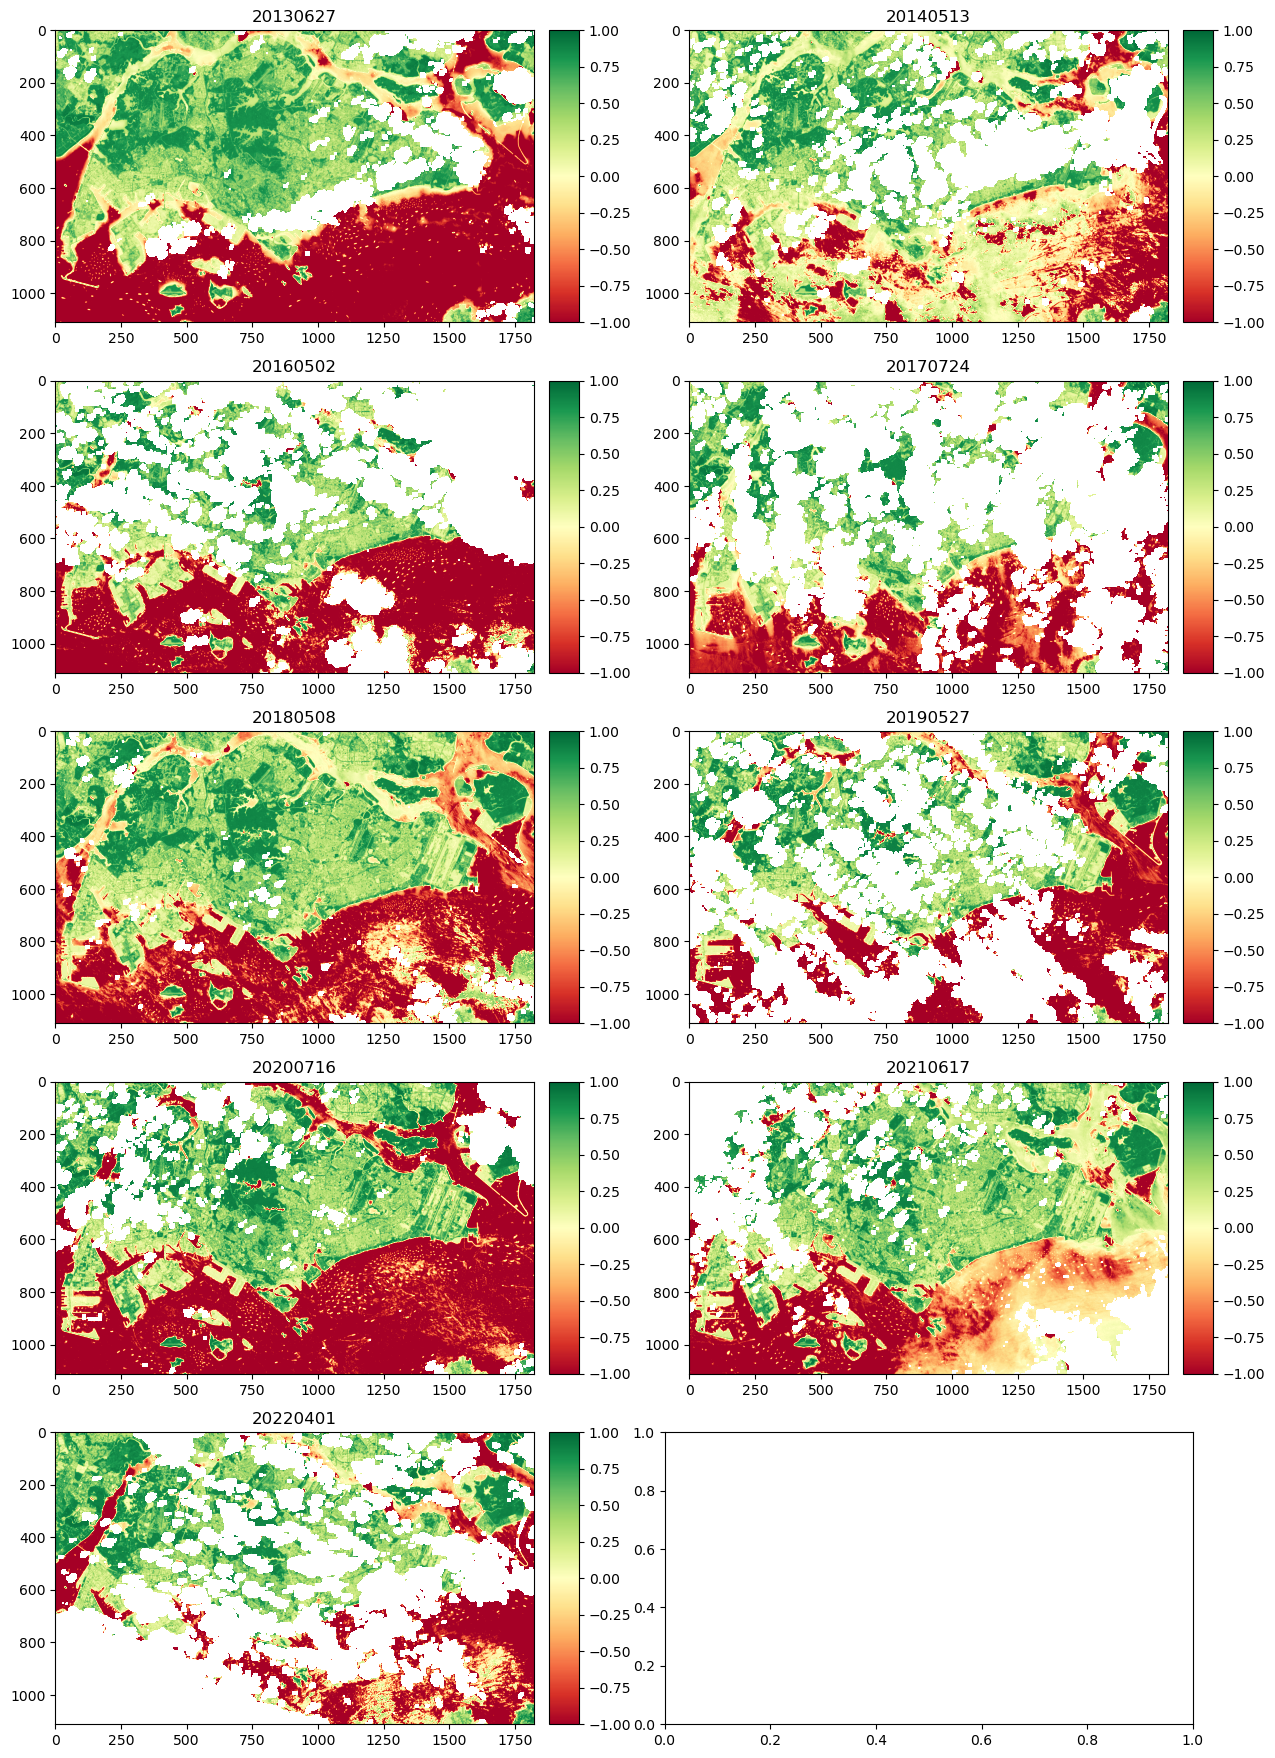

In [71]:
# plot all NDVI masked into a single 2 by 4 subplot
files = glob(
    # Note the syntax that you must use when you are searching through multiple folders
    # target_dir = 'C:\\Users\\tranq\\Documents\\Jupyter Root Folder\\Singapore NDVI\\data'
    os.path.join(target_dir, "*/*NDVI_MASKED.tif")
)

# Create subplot
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (15,22))
# flatten axs for easier iteration
axs = axs.flatten()

for idx, file in enumerate(files):
    with rio.open(file) as src:
        ndvi_masked = src.read(1, masked = True)
    src.close()
    
    im = axs[idx].imshow(ndvi_masked, cmap = "RdYlGn", vmin = -1, vmax = 1)
    axs[idx].set_title(f"{os.path.basename(file).split('_')[0]}")
    cax = fig.add_axes([axs[idx].get_position().x1+0.01,
                        axs[idx].get_position().y0,
                        0.02,
                        axs[idx].get_position().height])
    fig.colorbar(im, cax = cax)
    
plt.show();

In [113]:
# Use rasterstats to generate zonal stats for all years
files = glob(
    # Note the syntax that you must use when you are searching through multiple folders
    # target_dir = 'C:\\Users\\tranq\\Documents\\Jupyter Root Folder\\Singapore NDVI\\data'
    os.path.join(target_dir, "*/*NDVI_MASKED.tif")
)

sg_suburbs = gpd.read_file("sg_suburbs_cleaned.geojson")

for file in files:
    sg_ndvi = rasterstats.zonal_stats(
        "sg_suburbs_cleaned.geojson",
        file,
        # Note that rasterstats automatically runs masked version of the functions
        # Note that add_stats will calculate the added stats in addition to the default stats which 
        # include min, Max, mean, and count
        add_stats = {'masked_mean':np.ma.mean, "masked_median": np.ma.median}
    )
    
    sg_ndvi = pd.DataFrame(sg_ndvi)
    # Add prefix does NOT automatically add an underscore
    sg_ndvi = sg_ndvi.add_prefix(f"{os.path.basename(file).split('_')[0][:4]}_")
    
    sg_suburbs = pd.concat([sg_suburbs, sg_ndvi], axis = 1)

    
sg_suburbs.loc[53, ["2022_masked_median"]] = -1.0
sg_suburbs[["2022_masked_median"]] = sg_suburbs[["2022_masked_median"]].astype(float)

sg_suburbs

name  \
0                         Downtown Core   
1                           Bukit Batok   
2                                Tengah   
3                           Jurong West   
4                          Lim Chu Kang   
5                       Western Islands   
6                         Choa Chu Kang   
7               Western Water Catchment   
8                                  Tuas   
9                               Pioneer   
10                             Boon Lay   
11                         Sungei Kadut   
12                        Bukit Panjang   
13                     Southern Islands   
14                               Novena   
15                            Toa Payoh   
16                          Bukit Merah   
17                              Tanglin   
18                           Queenstown   
19              Central Water Catchment   
20                          Bukit Timah   
21                             Clementi   
22                         River Valley   
23                      Singapore River   
24                               Newton   
25                              Orchard   
26                               Outram   
27                               Museum   
28                               Bishan   
29                           Paya Lebar   
30                            Pasir Ris   
31                               Changi   
32                             Tampines   
33                                Bedok   
34                        Marine Parade   
35                              Geylang   
36                              Kallang   
37                               Rochor   
38                          Marina East   
39                         Marina South   
40                         Straits View   
41                North-Eastern Islands   
42                            Woodlands   
43                            Sembawang   
44                               Mandai   
45                               Yishun   
46                              Simpang   
47                              Seletar   
48                            Seng Kang   
49                              Punggol   
50                            Serangoon   
51                              Hougang   
52                           Ang Mo Kio   
53  Sembcorp Marine Tuas Boulevard Yard   
54                       Tuas Mega Port   
55                          Jurong East   

                                             geometry  2013_min  2013_max  \
0   POLYGON ((371740.714 142113.685, 371955.834 14... -1.000000  0.987891   
1   POLYGON ((362192.747 152536.286, 362055.609 15...  0.126720  0.907021   
2   POLYGON ((359614.641 149224.902, 359550.156 14...  0.221350  0.902245   
3   POLYGON ((358509.535 149245.710, 358510.108 14... -1.000000  0.962969   
4   POLYGON ((359861.582 157191.731, 359814.810 15... -1.000000  0.988476   
5   POLYGON ((350237.497 133640.364, 351984.375 13... -1.000000  0.997922   
6   POLYGON ((361434.117 153539.246, 361384.832 15...  0.085853  0.880597   
7   POLYGON ((354653.547 158873.396, 352900.666 15... -0.834774  0.958109   
8   POLYGON ((350008.856 136826.082, 350237.497 13... -1.000000  0.985107   
9   POLYGON ((352570.408 147159.986, 352518.444 14... -1.000000  0.932144   
10  POLYGON ((354981.786 146805.021, 354984.468 14... -1.000000  0.985731   
11  POLYGON ((363656.638 153707.301, 363602.527 15... -1.000000  0.998930   
12  POLYGON ((364153.970 148249.902, 364189.598 14...  0.140891  0.894965   
13  POLYGON ((365444.330 137807.558, 371043.232 13... -1.000000  0.948198   
14  POLYGON ((373440.794 147081.940, 373389.449 14... -1.000000  0.972822   
15  MULTIPOLYGON (((370802.666 148484.512, 370864....  0.111131  0.916049   
16  POLYGON ((370276.216 142758.535, 369273.436 14... -1.000000  0.983188   
17  POLYGON ((368275.692 143060.068, 368944.041 14...  0.226379  0.916800   
18  POLYGON ((362857.880 142798.209, 362805.370 14... -1.000000  0.995611   
19  POLYGON ((363349.520 155882.634, 363371

In [115]:
# Let's classify the NDVI values rather than just reporting floats
# Define the conditions and labels for reclassification

labels = ['No Vegetation', 'Slightly Dense', 'Moderately Dense', 'Highly Dense']

# def NDVI_reclassification(column):
#     conditions = [
#         (df[column] >= -1) & (df[column] < 0),
#         (df[column] >= 0.01) & (df[column] <= 0.3),
#         (df[column] >= 0.31) & (df[column] <= 0.6),
#         (df[column] >= 0.61) & (df[column] <= 1)
#     ]
    
#     labels = ['No Vegetation', 'Slightly Dense', 'Moderately Dense', 'Highly Dense']
    
#     return np.select(conditions, labels, default='Unknown')

def NDVI_reclassification(df):
    conditions = [
        (df >= -1) & (df < 0),
        (df >= 0) & (df < 0.2),
        (df >= 0.2) & (df < 0.4),
        (df >= 0.4) & (df < 0.6),
        (df >= 0.6) & (df < 0.8),
        (df >= 0.8) & (df <= 1)
    ]
    
    labels = ['No Vegetation', 'Bare Vegetation', 'Slightly Dense', 'Moderately Dense', 'Highly Dense', "Extremely Dense"]
    
    return np.select(conditions, labels, default='Unknown')

columns_to_reclassify = [
    "2013_mean", 
    "2014_mean",
    "2016_mean",
    "2017_mean",
    "2018_mean",
    "2019_mean",
    "2020_mean",
    "2021_mean",
    "2022_mean"
]

# Use numpy.select to reclassify the column
ndvi_cat = sg_suburbs[columns_to_reclassify].apply(NDVI_reclassification).add_prefix("cat_")

ndvi_cat = pd.concat([sg_suburbs[["name", "geometry"]], ndvi_cat], axis = 1)

ndvi_cat

name  \
0                         Downtown Core   
1                           Bukit Batok   
2                                Tengah   
3                           Jurong West   
4                          Lim Chu Kang   
5                       Western Islands   
6                         Choa Chu Kang   
7               Western Water Catchment   
8                                  Tuas   
9                               Pioneer   
10                             Boon Lay   
11                         Sungei Kadut   
12                        Bukit Panjang   
13                     Southern Islands   
14                               Novena   
15                            Toa Payoh   
16                          Bukit Merah   
17                              Tanglin   
18                           Queenstown   
19              Central Water Catchment   
20                          Bukit Timah   
21                             Clementi   
22                         River Valley   
23                      Singapore River   
24                               Newton   
25                              Orchard   
26                               Outram   
27                               Museum   
28                               Bishan   
29                           Paya Lebar   
30                            Pasir Ris   
31                               Changi   
32                             Tampines   
33                                Bedok   
34                        Marine Parade   
35                              Geylang   
36                              Kallang   
37                               Rochor   
38                          Marina East   
39                         Marina South   
40                         Straits View   
41                North-Eastern Islands   
42                            Woodlands   
43                            Sembawang   
44                               Mandai   
45                               Yishun   
46                              Simpang   
47                              Seletar   
48                            Seng Kang   
49                              Punggol   
50                            Serangoon   
51                              Hougang   
52                           Ang Mo Kio   
53  Sembcorp Marine Tuas Boulevard Yard   
54                       Tuas Mega Port   
55                          Jurong East   

                                             geometry     cat_2013_mean  \
0   POLYGON ((371740.714 142113.685, 371955.834 14...    Slightly Dense   
1   POLYGON ((362192.747 152536.286, 362055.609 15...  Moderately Dense   
2   POLYGON ((359614.641 149224.902, 359550.156 14...      Highly Dense   
3   POLYGON ((358509.535 149245.710, 358510.108 14...  Moderately Dense   
4   POLYGON ((359861.582 157191.731, 359814.810 15...      Highly Dense   
5   POLYGON ((350237.497 133640.364, 351984.375 13...     No Vegetation   
6   POLYGON ((361434.117 153539.246, 361384.832 15...  Moderately Dense   
7   POLYGON ((354653.547 158873.396, 352900.666 15...      Highly Dense   
8   POLYGON ((350008.856 136826.082, 350237.497 13...     No Vegetation   
9   POLYGON ((352570.408 147159.986, 352518.444 14...   Bare Vegetation   
10  POLYGON ((354981.786 146805.021, 354984.468 14...    Slightly Dense   
11  POLYGON ((363656.638 153707.301, 363602.527 15...  Moderately Dense   
12  POLYGON ((364153.970 148249.902, 364189.598 14...      Highly Dense   
13  POLYGON ((365444.330 137807.558, 371043.232 13...     No Vegetation   
14  POLYGON ((373440.794 147081.940, 373389.449 14...  Moderately Dense   
15  MULTIPOLYGON (((370802.666 148484.512, 370864....  Moderately Dense   
16  POLYGON ((370276.216 142758.535, 369273.436 14...    Slightly Dense   
17  POLYGON ((368275.692 143060.068, 368944.041 14...      Highly Dense   
18  POLYGON ((362857.880 142798.209, 362805.370 14...   Bare Vegetation   
19  POLYGON ((363349.520 155882.634, 363371.204 15...      Highly Dense   
20  POLY

C:\Users\tranq\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
C:\Users\tranq\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
C:\Users\tranq\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
C:\Users\tranq\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ver

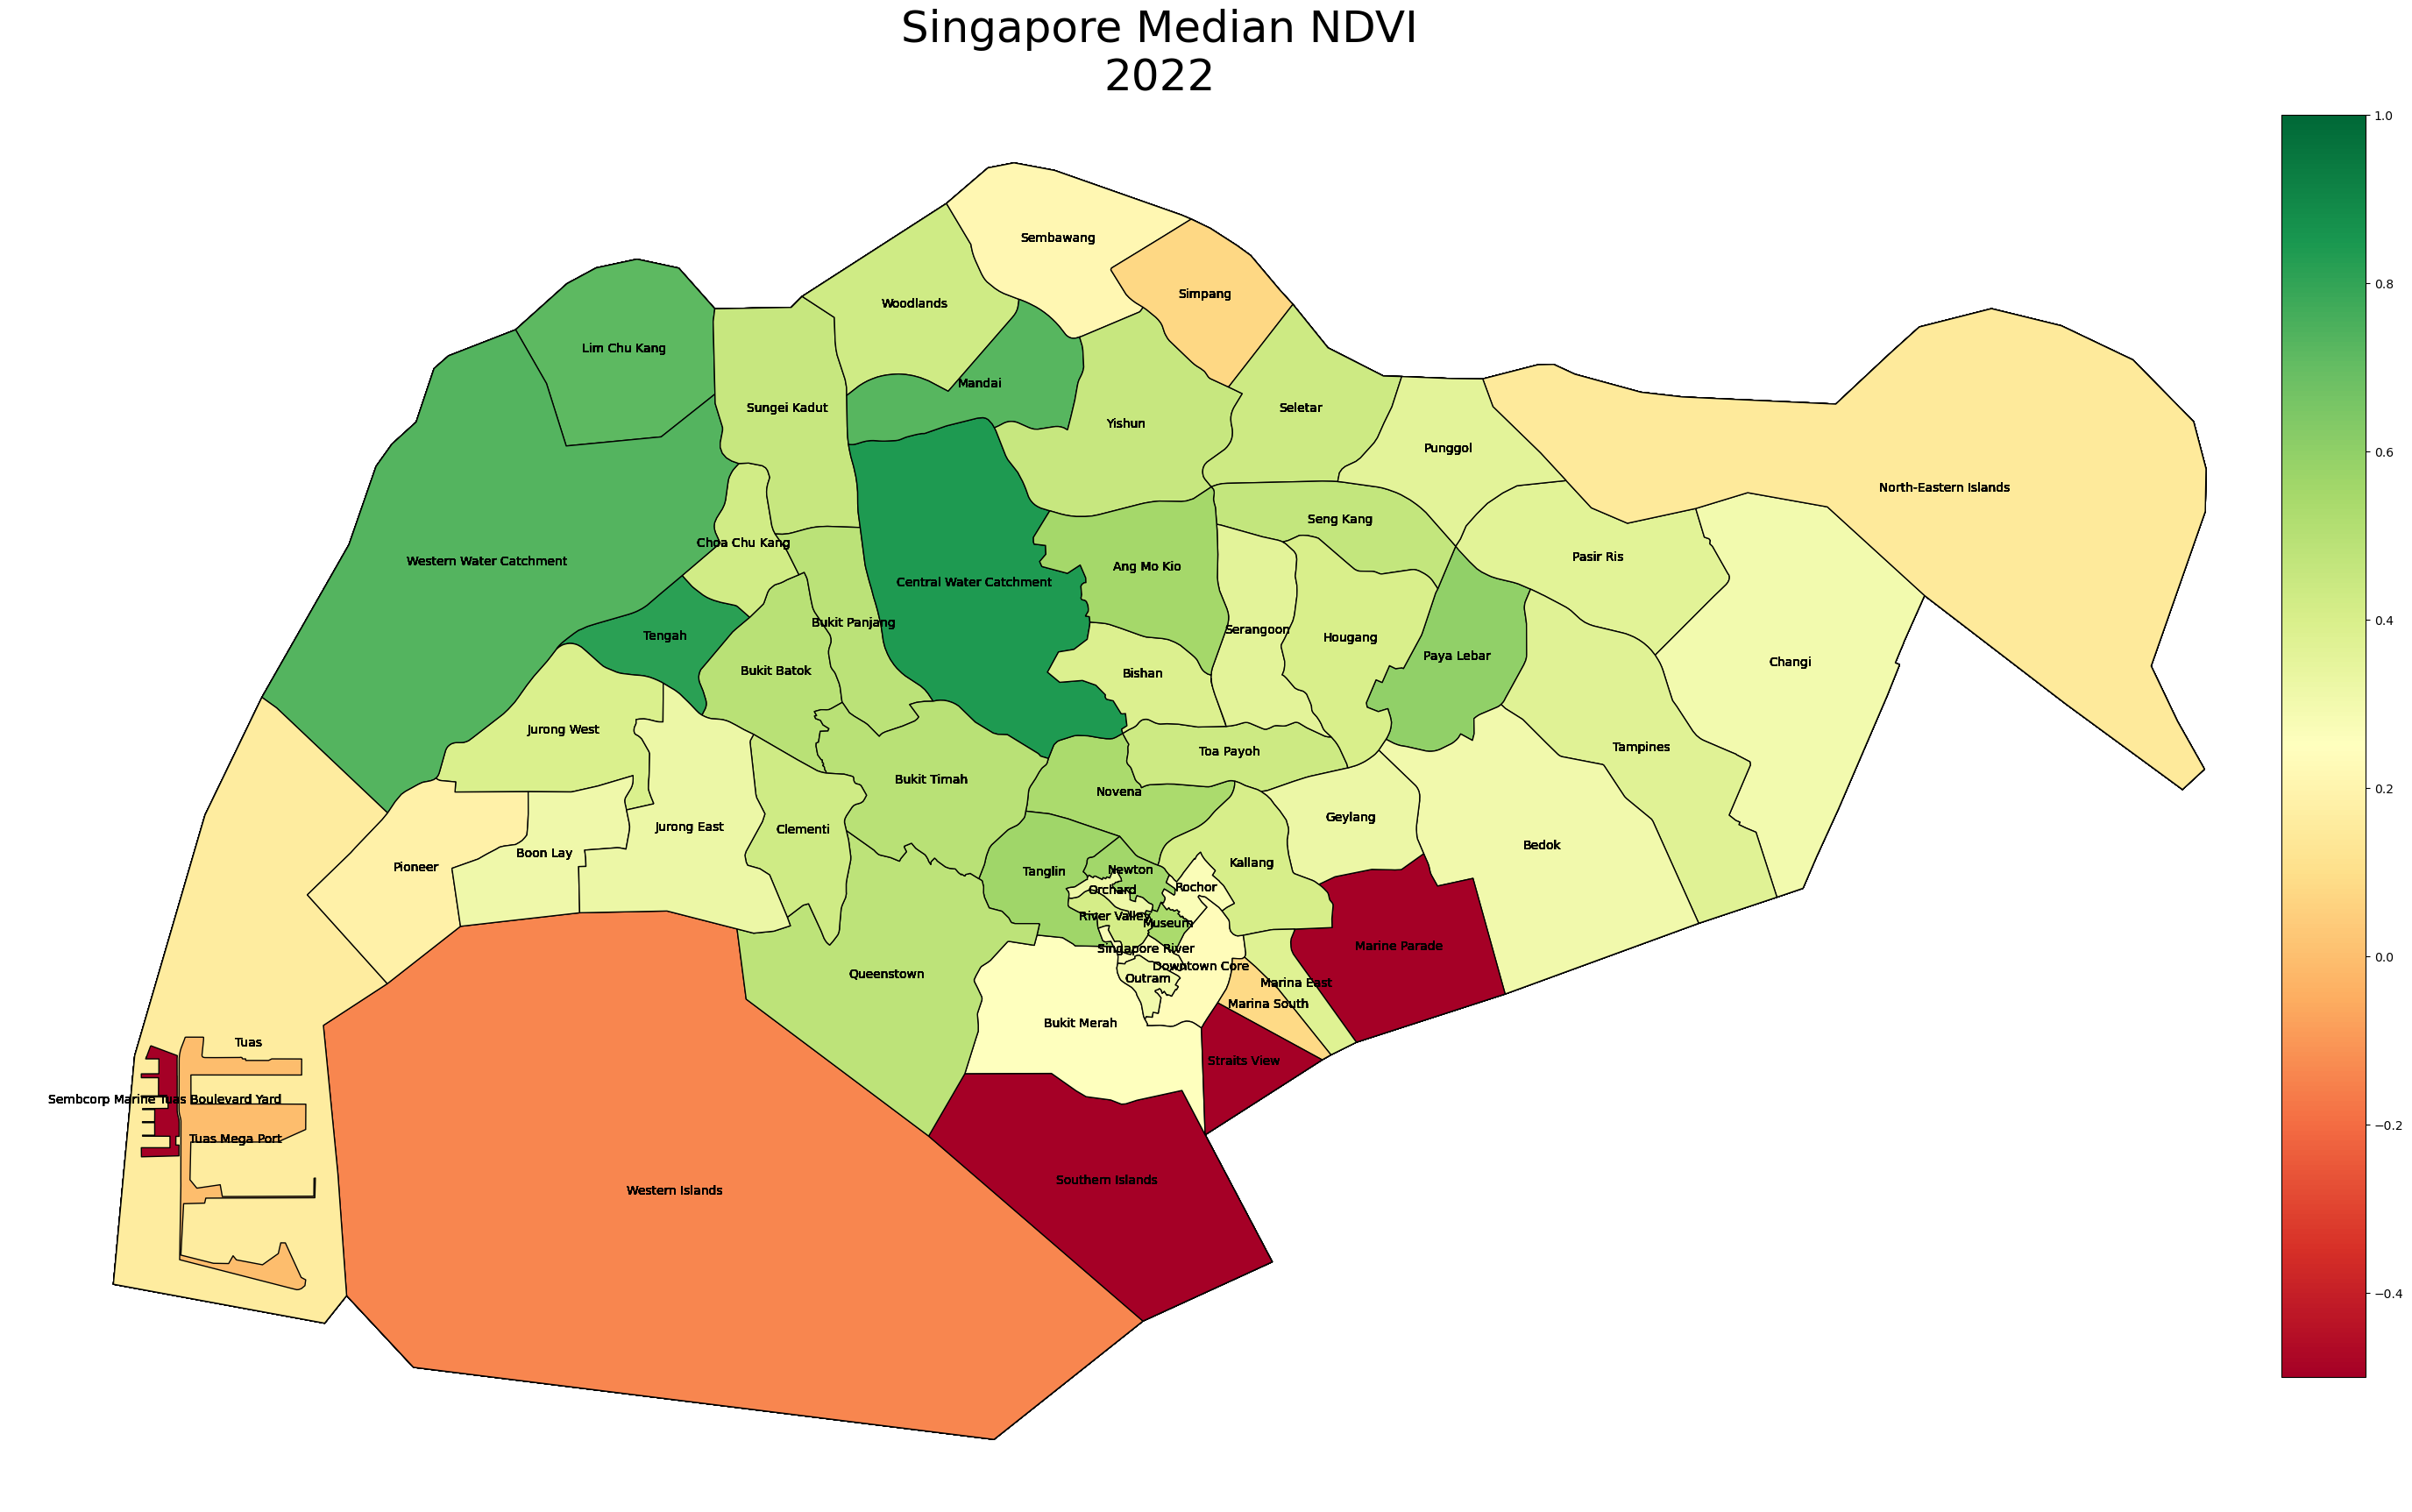

In [114]:
from matplotlib.animation import FuncAnimation

# %matplotlib qt5
fig, ax = plt.subplots(figsize = (32,18))
ax.axis("off")

ims = []

# Create a custom gradient cmap
# from matplotlib.colors import LinearSegmentedColormap
# cmap = LinearSegmentedColormap.from_list(
#     name='custom',
#     colors=['red', 'yellow', 'green'])

# This creates a colorbar that will stay on the animation
# Adds axes with the following arguments: left bottom width height
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap = "RdYlGn", norm=plt.Normalize(vmin = -0.5, vmax = 1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax)

columns_to_plot = [
    "2013_mean", 
    "2014_mean",
    "2016_mean",
    "2017_mean",
    "2018_mean",
    "2019_mean",
    "2020_mean",
    "2021_mean",
    "2022_mean"
]

# colorbar = plt.colorbar(ndvi_plot)
def update(frame):
    column = columns_to_plot[frame]
    
    if len(ims) > 0:
        del ims[0]

    # This is apparently how you animate with gpd plot
    artist = sg_suburbs.plot(ax = ax, column = f"{column[:4]}_masked_median", edgecolor = "black",
                             cmap = "RdYlGn", vmin = -0.5, vmax = 1)
    
    # Annotate municipality names
    sg_suburbs.apply(lambda x: ax.annotate(text = x["name"], 
                                       xy = x["geometry"].centroid.coords[0],
                                       ha = "center"), axis = 1)
    
    # colorbar = plt.colorbar(artist)
    
    ims.append(artist)
    
    ax.set_title(f"Singapore Median NDVI\n{column[:4]}", fontsize = 36)
    
    return ims

# Call the func animation class with the appropriate arguments. Frames indicates how many
# frames there will be IE how many frames will be passed into the `update` function, while
# repeat tells matplotlib whether to loop the animation, interval tells FuncAnimation how much time
# between frames
animation = FuncAnimation(fig, update, frames=len(columns_to_plot), repeat=True, interval = 1000)
plt.subplots_adjust(
    top=0.91,
    bottom=0.02,
    left=0.008,
    right=0.992,
    hspace=0.2,
    wspace=0.2
)

# Save the animation
animation_file = f'singapore_ndvi_animation_by_median.gif'
animation.save(animation_file, writer='pillow')

plt.show()

# Unhashable type maskedconstant in final year because some places completely covered by cloud cover
# i.e., no data

C:\Users\tranq\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
C:\Users\tranq\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
C:\Users\tranq\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
C:\Users\tranq\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
C:\Users\tranq\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
C:\Users\tranq\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color

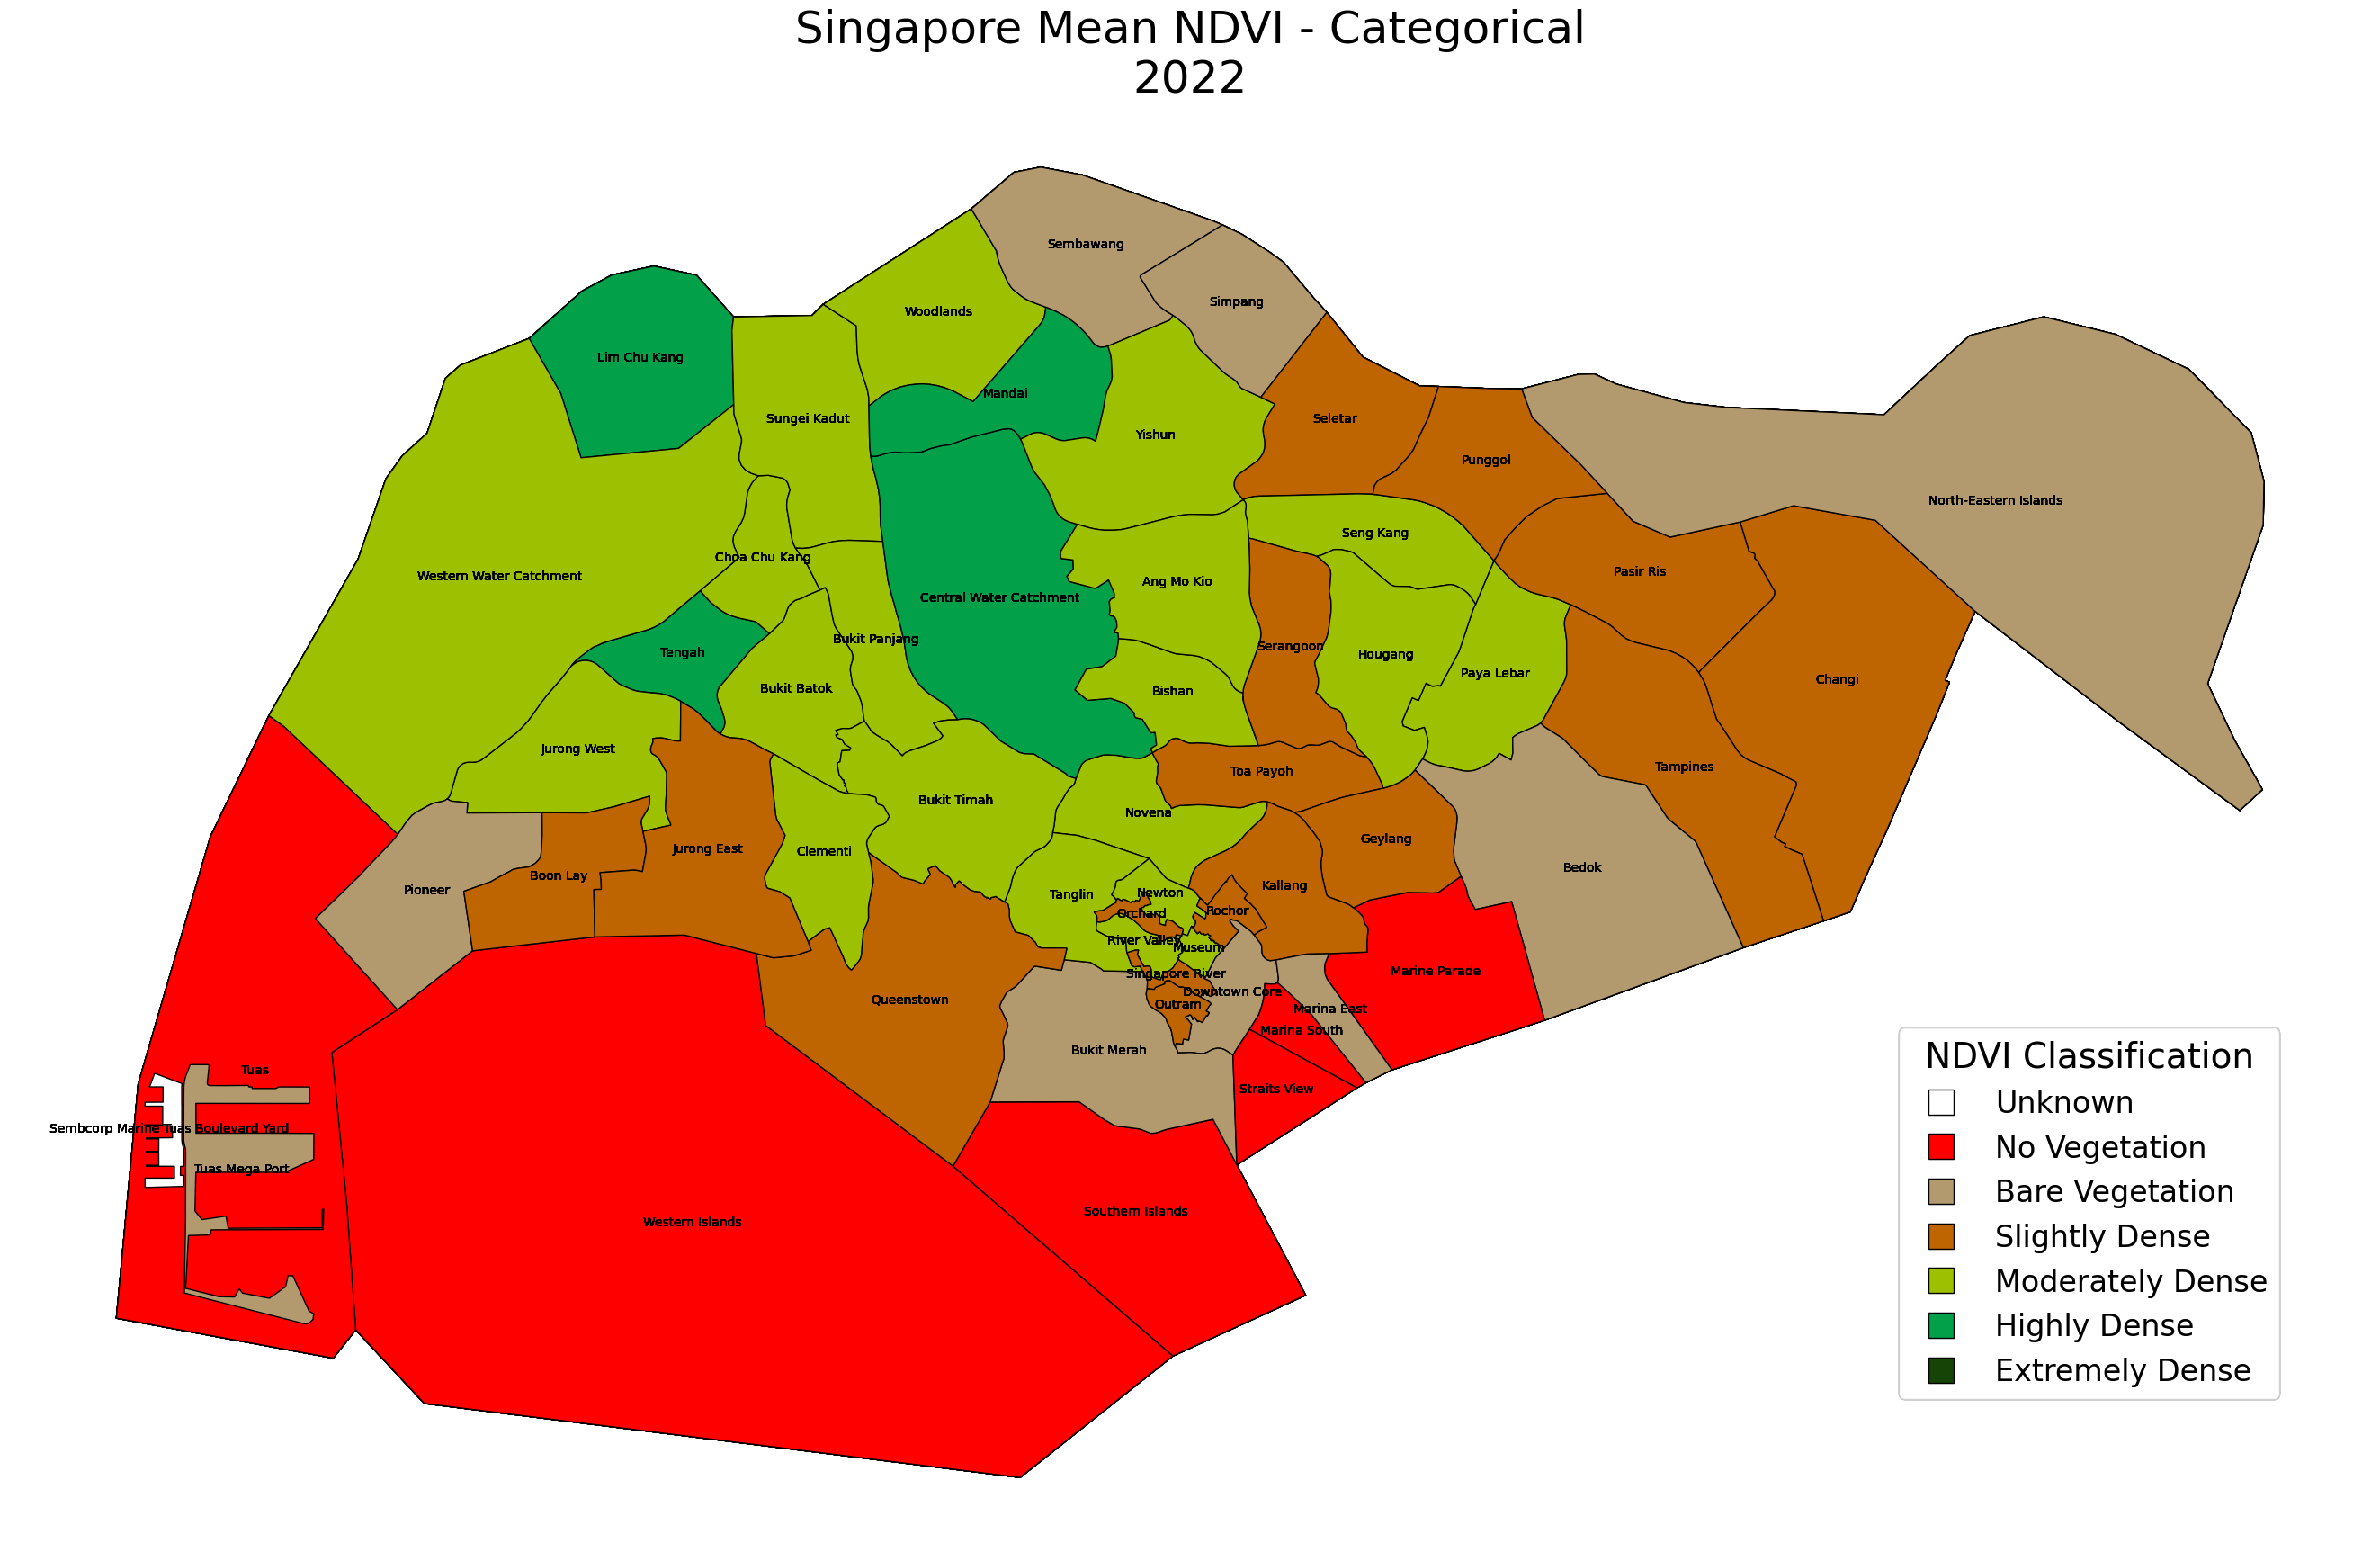

In [132]:
# Repeat the above but using categories in order to see changes more clearly
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D

# %matplotlib qt5
fig, ax = plt.subplots(figsize = (32,18))
ax.axis("off")

ims = []

columns_to_plot = [
    "2013_mean", 
    "2014_mean",
    "2016_mean",
    "2017_mean",
    "2018_mean",
    "2019_mean",
    "2020_mean",
    "2021_mean",
    "2022_mean"
]

# from matplotlib.colors import ListedColormap

cat_colors = {
    'Unknown': "white",
    'No Vegetation': "red", 
    'Bare Vegetation': "xkcd:dust",
    'Slightly Dense': "xkcd:orange brown", 
    'Moderately Dense': "xkcd:snot green", 
    'Highly Dense': "xkcd:emerald",
    "Extremely Dense": "xkcd:forrest green"
}

# colorbar = plt.colorbar(ndvi_plot)
def update(frame):
    column = columns_to_plot[frame]
    
    if len(ims) > 0:
        del ims[0]

    # This is apparently how you animate with gpd plot
    artist = ndvi_cat.plot(ax = ax, column = f"cat_{column[:4]}_mean", 
                           edgecolor = "black", categorical = True,
                           color = ndvi_cat[f"cat_{column[:4]}_mean"].map(cat_colors),
                           legend = True)
    
    # Annotate municipality names
    ndvi_cat.apply(lambda x: ax.annotate(text = x["name"], 
                                       xy = x["geometry"].centroid.coords[0],
                                       ha = "center"), axis = 1)
    
    # colorbar = plt.colorbar(artist)
    
    ims.append(artist)
    
    ax.set_title(f"Singapore Mean NDVI - Categorical\n{column[:4]}", fontsize = 36)
    
    # Manually make legend
    custom_points = [Line2D([0], [0], marker="s", linestyle="none", markersize=20, 
                            markeredgecolor = "black", color=color) for color in cat_colors.values()]
    leg_points = ax.legend(custom_points, 
                           cat_colors.keys(), 
                           title="NDVI Classification", 
                           loc=(0.8, .1),
                           fontsize = 24,
                          title_fontsize = 28)
    
    ax.add_artist(leg_points)
    
    return ims

# Call the func animation class with the appropriate arguments. Frames indicates how many
# frames there will be IE how many frames will be passed into the `update` function, while
# repeat tells matplotlib whether to loop the animation, interval tells FuncAnimation how much time
# between frames
animation = FuncAnimation(fig, update, frames=len(columns_to_plot), repeat=True, interval = 1000)
plt.subplots_adjust(
    top=0.91,
    bottom=0.02,
    left=0.008,
    right=0.992,
    hspace=0.2,
    wspace=0.2
)

# Save the animation
animation_file = f'singapore_ndvi_animation_by_mean_cat.gif'
animation.save(animation_file, writer='pillow')

plt.show()

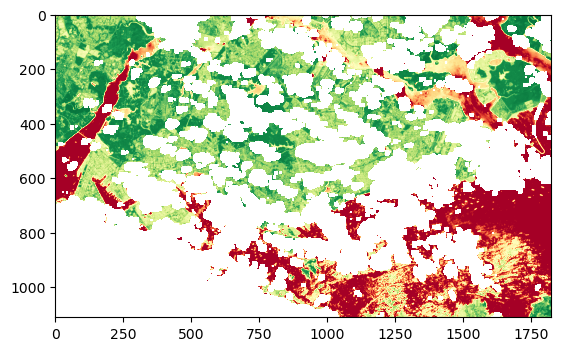

<Axes: >

In [66]:
# Testing - it looks like everything worked fine
# remember that when you import NDVI masked, you must include masked equals true when 
# reading it in
folder = "LC08_L2SP_125059_20220401_20220406_02_T1"

file = glob(
    os.path.join(
            target_dir,
            folder,
            "*_NDVI_MASKED.tif",
    )
)

src = rio.open(file[0])
ndvi = src.read(1, masked = True)

show(ndvi, cmap = "RdYlGn")

In [56]:
ndvi

array([[ 8.19317368e-01,  7.87494271e-01,  7.20491017e-01, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       [ 8.53669397e-01,  8.34154234e-01,  7.28572575e-01, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       [ 8.32944076e-01,  8.77237068e-01,  7.39641675e-01, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       ...,
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03, ...,
         6.19844421e-01,  6.01629813e-01,  5.65916659e-01],
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03, ...,
         6.79529356e-01,  6.12470504e-01,  5.47824576e-01],
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03, ...,
         6.15281188e-01,  6.13149249e-01,  6.73780785e-01]])

C:\Users\tranq\AppData\Local\Temp\ipykernel_11016\3563848738.py:1: RuntimeWarning: divide by zero encountered in divide
  ndvi = (nir - red) / (nir + red)


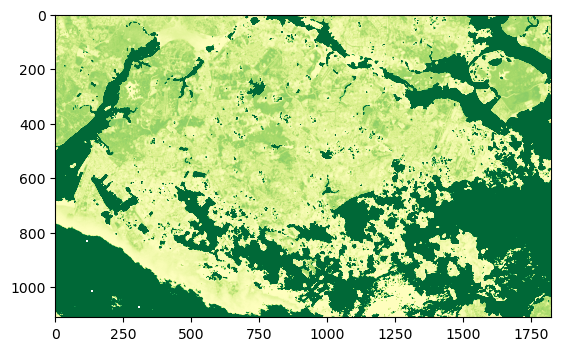

In [45]:
ndvi = (nir - red) / (nir + red)


plt.imshow(ndvi, cmap = "RdYlGn", vmin = -1, vmax = 1)

In [35]:
cl_mask_profile = profile.update(count = 1, dtype = np.uint8, nodata = 255)

cl_mask_profile

In [28]:
os.path.join(
            target_dir,
            folder,
            f"{folder.split('_')[3]}_CLOUD_MASK.tif",
        )

'C:\\Users\\tranq\\Documents\\Jupyter Root Folder\\Singapore NDVI\\data\\LC08_L2SP_125059_20220401_20220406_02_T1\\20220401_CLOUD_MASK.tif'

In [34]:
np.array([True, True, False]).dtype

np.bool_

numpy.bool_

In [37]:
profile

{'driver': 'GTiff', 'dtype': <class 'numpy.uint8'>, 'nodata': 255, 'width': 1823, 'height': 1112, 'count': 1, 'crs': CRS.from_epsg(32648), 'transform': Affine(30.0, 0.0, 344143.0,
       0.0, -30.0, 163234.0), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}